<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/spectrum_v2-1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Enviroment

## Loading Drive and folders

In [1]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [2]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Cambiar el numero aqui para cambiar los paths.
worker = workers[0]

if worker == "Ronald":
  path= "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

## Loading Necesary Libraries

In [3]:
# Importing necesary libraries
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
import seaborn as sn
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [4]:
#data_path=path+"/Spectrum"

#qpsk_path="/QPSK/A.10hops100km/"
#qam_path="/16QAM/A.10hops100km"

#file_name="/dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_10x100.xlsx"
#file_name = "/QPSK_dummy.xlsx"
# Skipping first row since only contain "Frequency" headers
#df_qpsk = pd.read_excel(data_path+qpsk_path+file_name, sheet_name = "Sheet1", skiprows=1)

#file_name="/dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_10x100.xlsx"
#file_name = "/16QAM_dummy.xlsx"
#df_qam = pd.read_excel(data_path+qam_path+file_name, sheet_name = "Sheet1", skiprows=1)

#Diff in column 5 to 1,286 0.03125

In [5]:
#dump_file = dict desireed to be saved
#filename = just the name of the file (file saved on "pickle_folder")

def pickle_out(dump_file, filename):
  filepath = path+"/pickle_folder/"+str(filename)+".pickle"
  pickleout = open(filepath, "wb")
  pickle.dump(dump_file, pickleout)
  pickleout.close()

def pickle_in(filename):
  filepath = path+"/pickle_folder/"+str(filename)+".pickle"
  picklein = open(filepath, "rb")
  loaded_dict = pickle.load(picklein)
  return loaded_dict

# Aggregator

In [6]:
def prime_number_finder(stop_gap, total_num_of_data):
  prime_nums = []
  i=2
  while i <= stop_gap:
    if (total_num_of_data % i==0):
      prime_nums.append(i)
    i+=1
  return prime_nums

In [7]:
def aggreagator_selection(stop_gap=25, total_num_of_data=1281, min_prime = False):
  current_freq_offset = 0.03125
  
  # Find the prime numbers where the total_num_of_data is divisible
  prime_nums = prime_number_finder(stop_gap, total_num_of_data)
  
  # Find the offsets of the new aggregators
  new_freq_offsets = []
  for nums in prime_nums:
    freq_offset = current_freq_offset*(nums-1)
    new_freq_offsets.append(freq_offset)

  # Select the prime number we would use to aggregation
  if min_prime == False:
    # Ask the user for the desired aggregator
    print('Please select one of the following prime number to conduct the aggregation {} with frequencies offsets of {}(PHz) respectively. (Current Freq offset is 0.03125 PHz)'.format(prime_nums, new_freq_offsets))
    while True:
      user_selection = input('Prime number to conduct the aggregation? ')
      if int(user_selection) not in prime_nums:
        print('Please select one of the available prime numbers. (Current selection is not avaliable)')
      else:
        break
    return int(user_selection)
  else:
    user_selection = min(prime_nums)
    freq_selected = min(new_freq_offsets)
    print('Selected the least common denominator for aggregation ({}) with a frequency of {}.'.format(user_selection, freq_selected))
    return int(user_selection)

In [8]:
def aggreagator(df, stop_gap=25, total_num_of_data=1281, min_prime = False):
  agg_num = aggreagator_selection(stop_gap, total_num_of_data, min_prime = min_prime)
  
  # Creating new df for aggregate values
  agg_df = pd.DataFrame()
  agg_df = df[df.columns[0:5]]

  agg=0
  loop_cnt=0
  init_column_cnt = 5
  while agg<=total_num_of_data:
    loop_cnt+=1
    # Obtain current last columns stop
    agg=agg_num+init_column_cnt
    # Select working columns
    new_df = df[df.columns[init_column_cnt:agg]]

    init_column_cnt += (agg_num)
    #print(init_column_cnt)
    # Get average of freq values for new header
    headers = list(new_df.columns.values)
    headers_array = np.asarray(headers)
    data_new = headers_array.astype(float)
    new_header_name = np.mean(data_new)

    # Add aggragated values to new df
    agg_df[str(new_header_name)] = new_df.mean(axis = 1)
  agg_dict = agg_df.to_dict()
  return agg_df, agg_dict


In [9]:
# QPSK AGG
#QPSK_agg_df, QPSK_agg_dict = aggreagator(df_qpsk, stop_gap=100, total_num_of_data=(df_qpsk.shape[1]-5), min_prime = True)
#pickle_out(QPSK_agg_dict, "test_agg_spectrum_QPSK_"+str(stop))

# Get model (Node and Power)

In [10]:
def get_dummy_spectrum(df, power):
  # Get selected power
  model_df = df[df['power_dBm'].isin([int(power)])]

  model_df = model_df.groupby(['#node', 'power_dBm']).mean()
  model_df.drop(['sampleid', 'Channels'], axis = 1, inplace = True)
  model_dict = model_df.to_dict()
  
  return model_df, model_dict
  #Return a tuple of (node, power) as keys in the nested dict and indexes

In [11]:
# Dummy Model QPSK
#QPSK_dummy_df, QPSK_dummy_dict = get_dummy_spectrum(df_qpsk, power = -2)

#pickle_out(QPSK_dummy_dict, "dummy_AGG_spectrum_QPSK")

In [12]:
#QPSK_dummy_df.head()

# Get Data (Node and Power)

In [13]:
# available filters are -2, -1, 0

def get_data_spectrum(df, node, power):
  # Get selected node
  data_df = df[df['#node'].isin([int(node)])]

  # Get selected power
  data_df = data_df[data_df['power_dBm'].isin([int(power)])]

  data_dict = data_df.to_dict()
  
  return data_df, data_dict
  #Return a tuple of (node, power) as keys in the nested dict and indexes

In [14]:
#data_df, data_dict = get_data_spectrum(df_qpsk, node=1, power=-2)

In [15]:
#data_df.head()

# Remove outliers

## Sample outliears remove

In [16]:
def remove_outliers(df, row_index, lower_qr=25, upper_qr=75):

  # IQR
  Q1 = np.percentile(df.iloc[[row_index]], lower_qr, interpolation = 'midpoint')
  
  Q3 = np.percentile(df.iloc[[row_index]], upper_qr, interpolation = 'midpoint')
  IQR = Q3 - Q1
  
  # Above Upper bound
  upper = df.iloc[[row_index]] >= (Q3+1.5*IQR)
  upper_bound_drop_cols = np.where(upper)[1]
  
  # Below Lower bound
  lower = df.iloc[[row_index]] <= (Q1-1.5*IQR)
  lower_bound_drop_cols = np.where(lower)[1]
  
  
  drop_cols = np.concatenate((upper_bound_drop_cols, lower_bound_drop_cols), axis=None)

  new_df = df.drop(df.columns[drop_cols], axis=1)
  
  new_sample = new_df.iloc[[row_index]]
  return new_sample, drop_cols

In [17]:
#df_qpsk_no_outliers, drop_cols = remove_outliers(data_df, row_index=0, lower_qr=15, upper_qr=85)

In [18]:
#df_qpsk_no_outliers.shape

In [19]:
#df_qpsk_no_outliers.head()

## Model match new sample df

In [20]:
def model_match_sample(model_df, sample_drop_cols):

  new_drop_cols = []
  for col in sample_drop_cols:
    new_drop_cols.append(int(col-4))

  new_model_df = model_df.drop(model_df.columns[new_drop_cols], axis=1)
  return new_model_df

In [21]:
#QPSK_dummy_df_no_outliers = model_match_sample(QPSK_dummy_df, drop_cols)

In [22]:
#display(QPSK_dummy_df_no_outliers)

In [23]:
def match_model_with_sample(model_df):
  model_df.insert(loc = 0, column = 'sampleid', value = 1)
  model_df.insert(loc = 1, column = 'Channels', value = 1)
  model_df.insert(loc = 3, column = 'power_dBm', value = 0)
  model_df.insert(loc = 4, column = '#node', value = 0)  
  
  row = 0
  for idx in model_df.index:
    model_df.iloc[row, [3]] = idx[1]
    model_df.iloc[row, [4]] = idx[0]
    row += 1

  return model_df

In [24]:
#match_QPSK_dummy_df_no_outliers = match_model_with_sample(QPSK_dummy_df_no_outliers)

In [25]:
#display(match_QPSK_dummy_df_no_outliers)

In [26]:
'''
print(data_df.shape)
print(df_qpsk_no_outliers.shape)
print(QPSK_dummy_df.shape)
print(QPSK_dummy_df_no_outliers.shape)
print(match_QPSK_dummy_df_no_outliers.shape)
'''

'\nprint(data_df.shape)\nprint(df_qpsk_no_outliers.shape)\nprint(QPSK_dummy_df.shape)\nprint(QPSK_dummy_df_no_outliers.shape)\nprint(match_QPSK_dummy_df_no_outliers.shape)\n'

# Separate tails

In [27]:
def tails_generator(row_df):
  total_columns = row_df.shape[1]-5
  mid_point = int(total_columns/2)

  new_sample = row_df.iloc[:, 0:5]
  mid_point = mid_point+5

  left_tail = row_df.iloc[:, 5:mid_point]
  rigth_tail = row_df.iloc[:, mid_point+1:row_df.shape[1]]

  return left_tail, rigth_tail


In [28]:
#sample_left_tail, sample_rigth_tail = tails_generator(df_qpsk_no_outliers)
#model_left_tail, model_rigth_tail = tails_generator(match_QPSK_dummy_df_no_outliers)

In [29]:
'''
print(sample_left_tail.shape)
print(sample_rigth_tail.shape)

print(model_left_tail.shape)
print(model_rigth_tail.shape)
'''

'\nprint(sample_left_tail.shape)\nprint(sample_rigth_tail.shape)\n\nprint(model_left_tail.shape)\nprint(model_rigth_tail.shape)\n'

In [30]:
#display(model_left_tail)

# Linear Regresion (Calculate R^2)

In [31]:
def linear_regression(sample_tail, model_tail, model_eval_node):
  
  model_eval_node = model_eval_node-1
  model_tail = model_tail.iloc[model_eval_node].to_numpy()

  y = np.array(model_tail)

  sample_tail = sample_tail.iloc[[0]].to_numpy()
  x = np.array(sample_tail).reshape((-1, 1))

  # Get linear regresion features
  model = LinearRegression()
  model.fit(x, y)
  model = LinearRegression().fit(x, y)
  r_sqr = model.score(x, y)

  return r_sqr

# intercept = model.intercept_
# slope = model.coef_

In [32]:
#left_r_sqr = linear_regression(sample_left_tail, model_left_tail, model_eval_node = 1)
#rigth_r_sqr = linear_regression(sample_rigth_tail, model_rigth_tail, model_eval_node = 1)

# Confusion Matrix

In [33]:
def confusion_matrix(y_actual, y_pred, filepath_to_save, power):
  # Setting the figure size
  fig = plt.figure(figsize=(7,5))

  data = {'y_Actual':    y_actual,
          'y_Predicted': y_pred}

  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

  sn.heatmap(confusion_matrix, annot=True, cbar=False, cmap='Blues')

  # Give a title to the graph
  plt.title('Confusion Matrix Nodes Samples with Power '+ str(power)) 

  #Saving the plot as an image
  fig.savefig(filepath_to_save, bbox_inches='tight', dpi=150)
  plt.show()

# Classifier

In [34]:
def classifier(eval_df, model_df, filepath_confusion_m, aggregate = False, aggregate_min_prime = False, lower_qr  = 15, upper_qr = 85):
  true_storage = {}
  predit_storage = {}

  # obtain the distances available in eval_df
  distances = []
  for distance_val in eval_df['Distance_km'].unique():
    distances.append(distance_val)

  # Select model data that only contain the distances available in the sample file
  model_df = model_df.loc[model_df['Distance_km'].isin(distances)]

  # Conduct aggregation if requested
  if aggregate == True:
    eval_df, eval_agg_dict = aggreagator(eval_df, stop_gap=100, total_num_of_data=(eval_df.shape[1]-5), min_prime = aggregate_min_prime)
    new_dummy_df, model_agg_dict = aggreagator(model_df, stop_gap=100, total_num_of_data=(model_df.shape[1]-5), min_prime = aggregate_min_prime)
  
  # Loop each power available
  for power_row in eval_df['power_dBm'].unique():
    
    y_actual = np.array([])
    y_predit = np.array([])
    print('--- Evaluating Power {} ---'.format(power_row))

    if aggregate == True:
      model_df = new_dummy_df
    # ---------------- This should be modified once we have the real model dataset ----------------
    model_dummy_df, model_dummy_dict = get_dummy_spectrum(model_df, power = power_row)

    # Loop each distance available
    for node_row in eval_df['#node'].unique():
      data_df, data_dict = get_data_spectrum(eval_df, node = node_row, power = power_row)
          
      #Actual values
      y_actual_node = data_df['#node'].to_numpy()

      # Loop each sample row
      for row in range(data_df.shape[0]):
        # Remove outliers from sample data
        df_data_no_outliers, drop_cols = remove_outliers(data_df, row_index = row, lower_qr = lower_qr, upper_qr = upper_qr)
        
        # Match model data with new sample data after outliers removed
        model_dummy_df_no_outliers = model_match_sample(model_dummy_df, drop_cols)

        match_model_dummy_df_no_outliers = match_model_with_sample(model_dummy_df_no_outliers)

        # Obtain tails of sample and model data
        sample_left_tail, sample_rigth_tail = tails_generator(df_data_no_outliers)
        model_left_tail, model_rigth_tail = tails_generator(match_model_dummy_df_no_outliers)

        r_sqr_storage = []
        # Loop through each model node available
        for model_row in range(match_model_dummy_df_no_outliers.shape[0]):
          
          # Calculate R_sqr between sample and model
          left_r_sqr = linear_regression(sample_left_tail, model_left_tail, model_eval_node = (model_row+1))
          rigth_r_sqr = linear_regression(sample_rigth_tail, model_rigth_tail, model_eval_node = (model_row+1))
          mean_r_sqr  = (left_r_sqr+rigth_r_sqr)/2
          r_sqr_storage.append(mean_r_sqr)
        
        # Select the highest r_sqr position (Predicted Node)
        maxval = np.amax(r_sqr_storage)
        indice = np.where(r_sqr_storage == np.amax(r_sqr_storage))
        pos_max = indice[0][0]+1    

        #y_predit.append(pos_max)
        y_predit = np.append(y_predit, pos_max)
      y_actual = np.concatenate((y_actual, y_actual_node), axis=0)
    
    y_predit = y_predit.astype(int)
    y_actual = y_actual.astype(int)
    
    true_storage['Power_'+str(power_row)] = y_actual
    predit_storage['Power_'+str(power_row)] = y_predit

    # Confusion matrix
    filepath_m = filepath_confusion_m +'Power_'+ str(power_row) +'.jpg'

    confusion_matrix(y_actual, y_predit, filepath_m, power=power_row)

    print('F1 score {}'.format(f1_score(y_actual, y_predit, average='weighted')))

  return y_actual, y_predit, true_storage, predit_storage

In [35]:
#save_confusion_filepath = path + '/plots/spectrum/10hops100km_confusion_matrix_'
#y_actual, y_predit, true_storage, predit_storage = classifier(df_qpsk, df_qpsk, filepath_confusion_m = save_confusion_filepath, aggregate = False, aggregate_min_prime = False, lower_qr  = 0, upper_qr = 100)

In [36]:
#print(true_storage)

#print(predit_storage)

# Test additional scenarios

In [37]:
qpsk_data_path=path+"/Spectrum/QPSK"

qam_data_path=path+"/Spectrum/16QAM"

# Test files

# QPSK files
files_to_evaluate_qpsk = []
for subdir, dirs, files in os.walk(qpsk_data_path):
    for file in files:
        if "dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_" in file:
          files_to_evaluate_qpsk.append(os.path.join(subdir, file))

# QAM files
files_to_evaluate_qam = []
for subdir, dirs, files in os.walk(qam_data_path):
    for file in files:
        if "dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_" in file:
          files_to_evaluate_qam.append(os.path.join(subdir, file))

# Model files
qpsk_model = qpsk_data_path + '/A.10hops100km/dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_10x100.xlsx'
qam_model = qam_data_path + '/A.10hops100km/dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_10x100.xlsx'

In [38]:
# Model df
#df_model = pd.read_excel(qpsk_model, sheet_name = "Sheet1", skiprows=1)
def spectrum_classifier(files_to_evaluate):
  for file_x in files_to_evaluate:
    try:
      print('--- Evaluating {} ---'.format(file_x[file_x.find('dataSet') : file_x.find('.xlsx')]))
      
      # Confusion Matrix filepath
      confusion_m_filename = (file_x[file_x.find('Samples') : file_x.find('.xlsx')])+'_Confusion_Matrix.jpg'
      save_confusion_filepath = path + '/plots/spectrum/'+confusion_m_filename
      
      # Samples df
      # Skipping first row since only contain "Frequency" headers
      df = pd.read_excel(file_x, sheet_name = "Sheet1", skiprows=1)
      
      # Run classifier
      y_actual, y_predit, true_storage, predit_storage = classifier(df, df, filepath_confusion_m = save_confusion_filepath, aggregate = False, aggregate_min_prime = False, lower_qr  = 0, upper_qr = 100)
      print('\n')
    except:
      print('--- Fail to evaluate. ---')
      print('Files is open: {}'.format(file_x))
      print('\n')

# Running Test

--- Evaluating dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_4x250 ---
--- Evaluating Power -2 ---


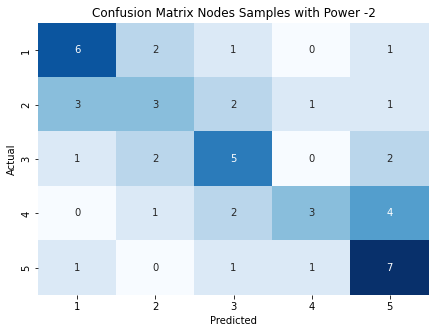

F1 score 0.46819047619047616
--- Evaluating Power -1 ---


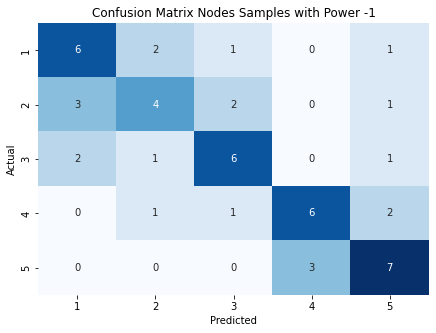

F1 score 0.5767631199210147
--- Evaluating Power 0 ---


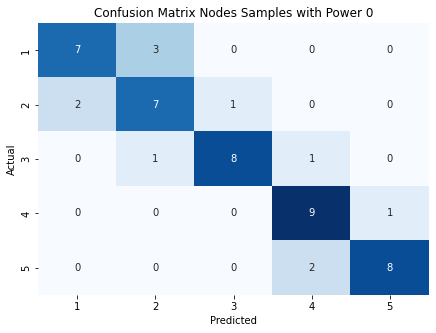

F1 score 0.7811802232854865


--- Evaluating dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_10x100 ---
--- Fail to evaluate. ---
Files is open: /content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset/Spectrum/QPSK/A.10hops100km/~$dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_10x100.xlsx


--- Evaluating dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_10x100 ---
--- Evaluating Power -2.0 ---


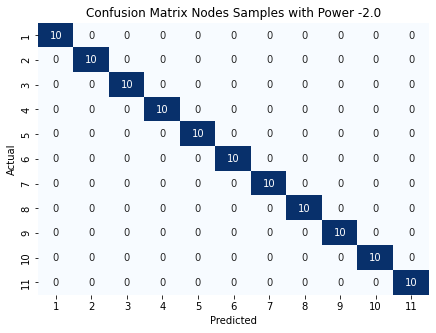

F1 score 1.0
--- Evaluating Power -1.0 ---


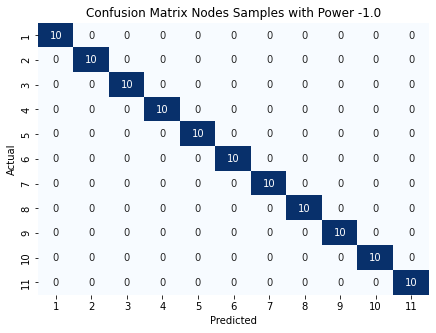

F1 score 1.0
--- Evaluating Power 0.0 ---


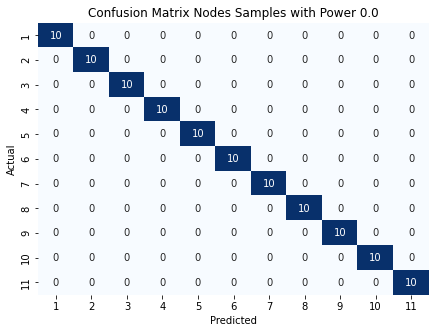

F1 score 1.0


--- Evaluating dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_8x125 ---
--- Evaluating Power -2 ---


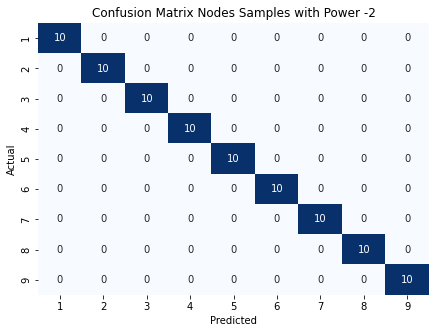

F1 score 1.0
--- Evaluating Power -1 ---


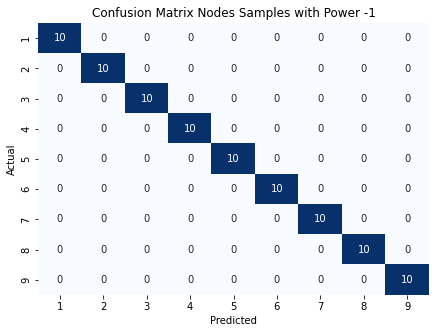

F1 score 1.0
--- Evaluating Power 0 ---


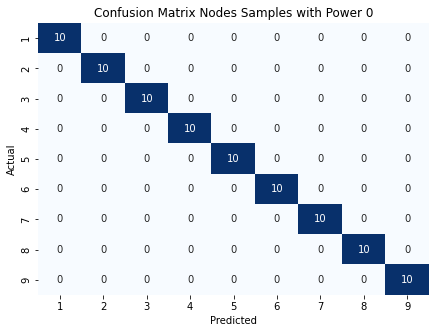

F1 score 1.0


--- Evaluating dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_5x200 ---
--- Evaluating Power -2 ---


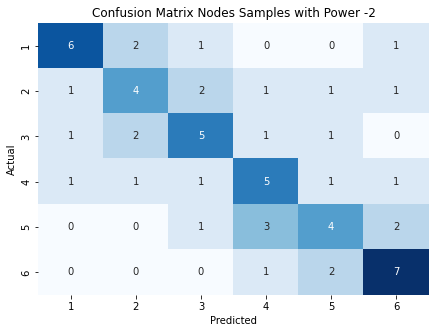

F1 score 0.5143730538467381
--- Evaluating Power -1 ---


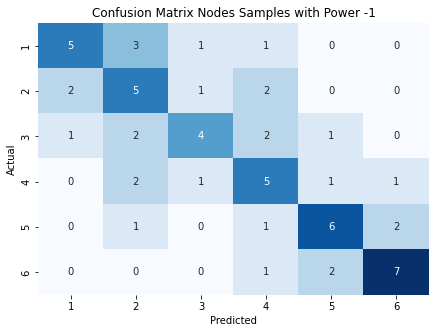

F1 score 0.5359119756817967
--- Evaluating Power 0 ---


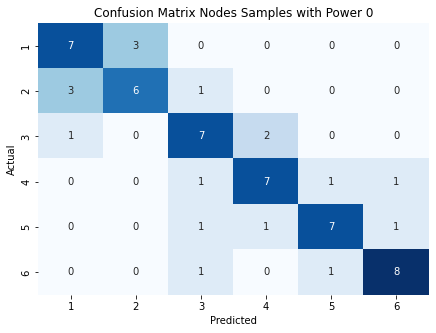

F1 score 0.7002923976608186


--- Evaluating dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_2x500 ---
--- Evaluating Power -2 ---


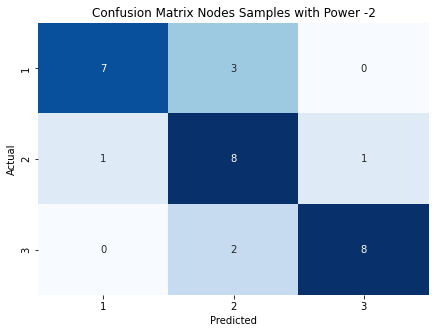

F1 score 0.7718450716162387
--- Evaluating Power -1 ---


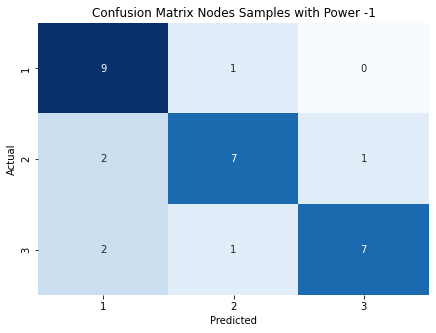

F1 score 0.7657428595643697
--- Evaluating Power 0 ---


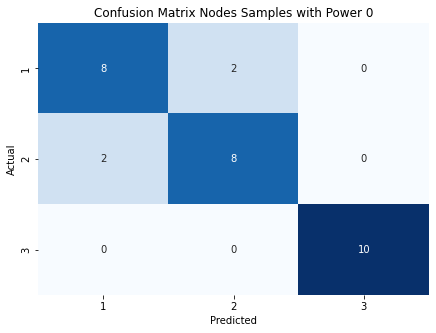

F1 score 0.8666666666666668




In [39]:
# QPSK
spectrum_classifier(files_to_evaluate_qpsk)

--- Evaluating dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_4x250 ---
--- Evaluating Power -2 ---


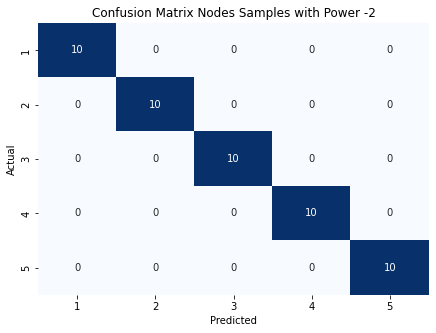

F1 score 1.0
--- Evaluating Power -1 ---


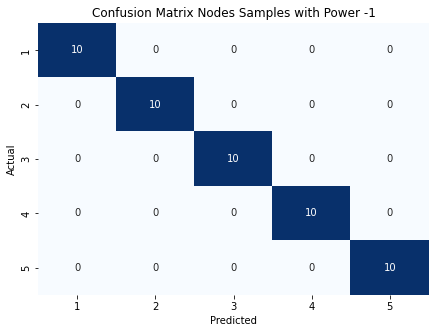

F1 score 1.0
--- Evaluating Power 0 ---


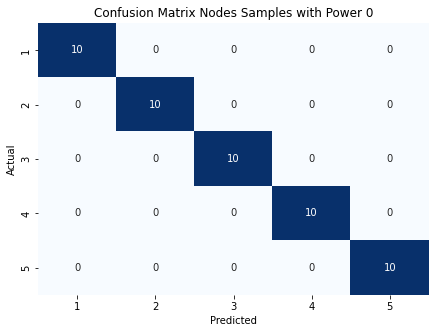

F1 score 1.0


--- Evaluating dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_2x500 ---
--- Evaluating Power -2 ---


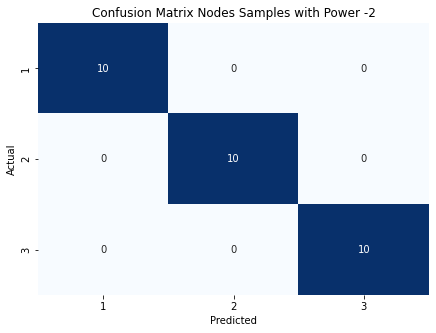

F1 score 1.0
--- Evaluating Power -1 ---


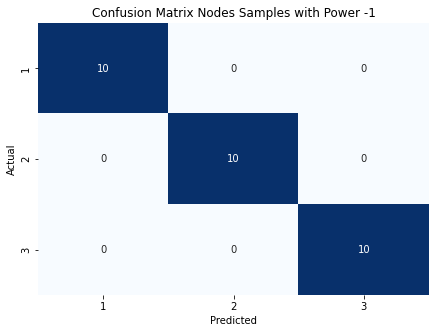

F1 score 1.0
--- Evaluating Power 0 ---


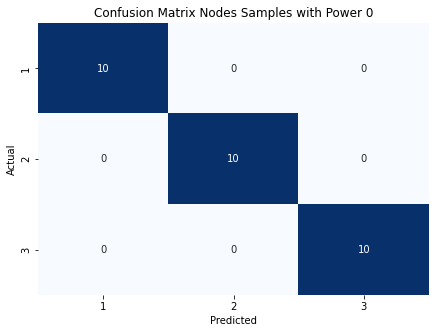

F1 score 1.0


--- Evaluating dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_8x125 ---
--- Evaluating Power -2 ---


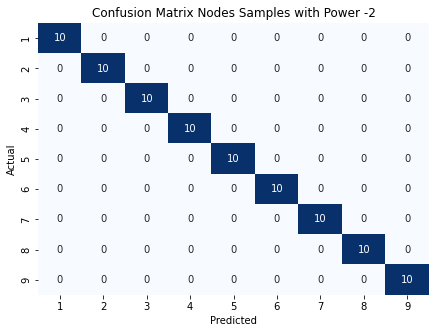

F1 score 1.0
--- Evaluating Power -1 ---


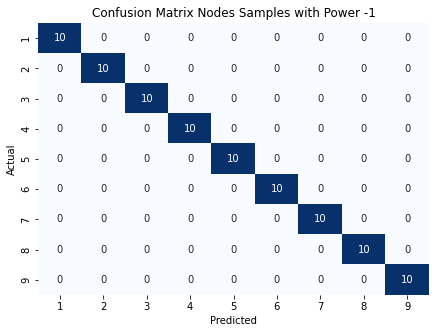

F1 score 1.0
--- Evaluating Power 0 ---


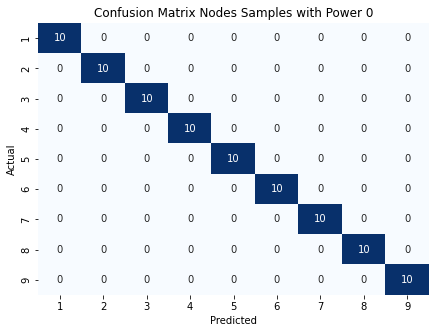

F1 score 1.0


--- Evaluating dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_5x200 ---
--- Evaluating Power -2 ---


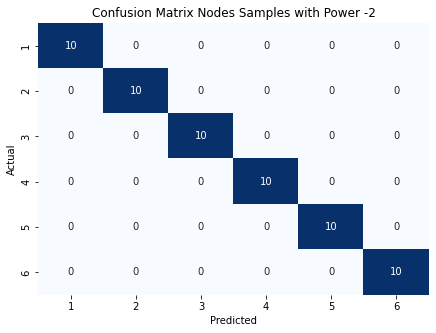

F1 score 1.0
--- Evaluating Power -1 ---


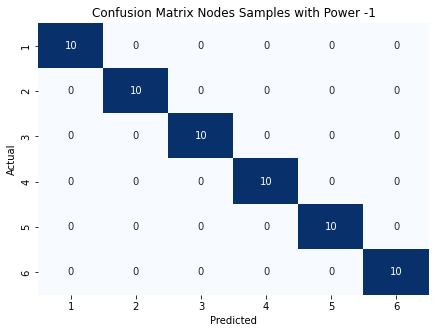

F1 score 1.0
--- Evaluating Power 0 ---


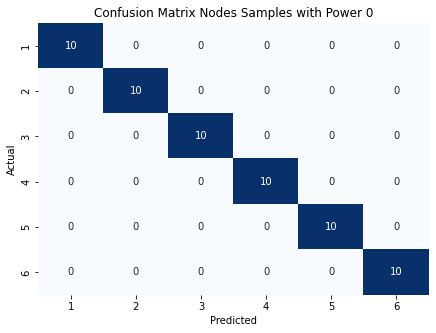

F1 score 1.0


--- Evaluating dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_10x100 ---
--- Evaluating Power -2 ---


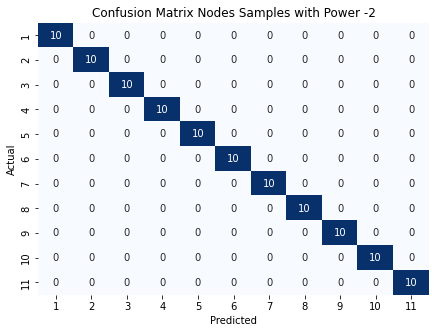

F1 score 1.0
--- Evaluating Power -1 ---


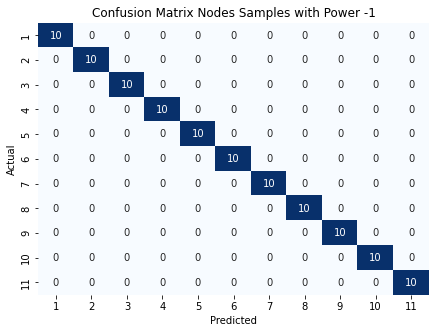

F1 score 1.0
--- Evaluating Power 0 ---


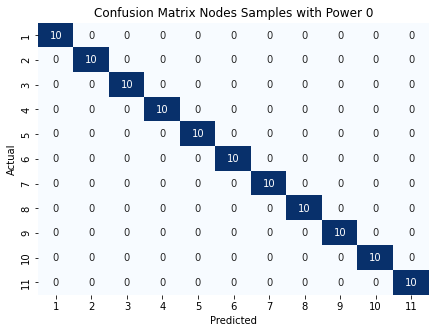

F1 score 1.0




In [40]:
# QAM
spectrum_classifier(files_to_evaluate_qam)